## Feature selection: text

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectFromModel

import os
#os.environ["PATH"] += os.pathsep + 'C:\\Users\\jander33\\Desktop\\project_5\\programs\\graphviz\\bin'


import sys

sys.path.append('../code/quickpipeline')
sys.path.append('../code/cleaners')
sys.path.append('../code/features')
#sys.path.append(r'C:\\Users\\jander33\\Desktop\\project_5\\programs')
#sys.path.append(r'C:\Miniconda3\envs\tf\Lib\site-packages')
#print(sys.path)


from quickpipeline import QuickPipeline
from J_cleaner import *
from j_features import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

/Users/jacob/anaconda3/envs/DL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jacob/anaconda3/envs/DL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
df = pd.read_csv('../data/processed2/class_dfs/WR_27_w2v.csv')
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [4]:
data = pd.read_csv('../data/processed2/WR_27_p2.csv')
data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [5]:
w2v = df[['Prime', 'Competitor', 'Program', 'mstr_agt_cd', 
          'pri_agt_cd', 'sub_agt_cd', 'insured_zip_cd']]


In [6]:
df.drop(['SAI', 'Policy_num', 'pri_agt_cd'], axis=1, inplace=True)

In [7]:
y = data[['TRV.Win']]

#y['TRV.Win'].value_counts()

In [8]:
#j_factors('insured_zip_cd', df, 20) # over 1k: prime, mstr, sub, zip

### Freq features

In [9]:
#Competitor
prog_dict = make_dict('Competitor', df)
df['comp_freq'] = df['Competitor'].map(prog_dict)

df['Comp_rev'] = df['comp_freq'].apply(lambda x: freq_group(x, prog_dict, 10, 50, 100))
df.drop(['Competitor'], axis=1, inplace=True)

In [10]:
#Program
prog_dict = make_dict('Program', df)
df['program_freq'] = df['Program'].map(prog_dict)

df['program_rev'] = df['program_freq'].apply(lambda x: freq_group(x, prog_dict, 20, 80, 150))
df.drop(['Program'], axis=1, inplace=True)

In [11]:
#df['program_rev'].value_counts()

In [12]:
#prime
prime_dict = make_dict('Prime', df)
df['prime_freq'] = df['Prime'].map(prime_dict)
df.drop(['Prime'], axis=1, inplace=True)

In [13]:
#mstr_agt_cd
mstr_dict = make_dict('mstr_agt_cd', df)
df['mstr_freq'] = df['mstr_agt_cd'].map(mstr_dict)
df.drop(['mstr_agt_cd'], axis=1, inplace=True)

In [14]:
#sub_agt_cd
sub_dict = make_dict('sub_agt_cd', df)
df['sub_freq'] = df['sub_agt_cd'].map(sub_dict)
df.drop(['sub_agt_cd'], axis=1, inplace=True)

In [15]:
#insured_zip_cd
zip_dict = make_dict('insured_zip_cd', df)
df['zip_freq'] = df['insured_zip_cd'].map(zip_dict)
df.drop(['insured_zip_cd'], axis=1, inplace=True)

### W2V feature

In [16]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence

from keras.preprocessing.text import Tokenizer


/Users/jacob/anaconda3/envs/DL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
w2v = w2v.astype(str)
junk = w2v.apply(lambda x: ' '.join(x), axis=1)

In [18]:
token = Tokenizer()
token.fit_on_texts(junk)
sequences = token.texts_to_sequences(junk) # list
#word_index = token.word_index # type = dict
w2v_matrix = pad_sequences(sequences, maxlen = None) 

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(w2v_matrix)
w2v_feat = pca.transform(w2v_matrix)

/Users/jacob/anaconda3/envs/DL/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [20]:
df.head()

,comp_freq,Comp_rev,program_freq,program_rev,prime_freq,mstr_freq,sub_freq,zip_freq
0,183,Harleysville,617,RESTAURANT ORIENTAL-FAMILY STY,32,32,32,12
1,8398,Other,1475,BLDG PAC MERCANTILE OTHER,4,4,4,6
2,5535,Hartford,557,OFC PAC DENTISTS,24,24,12,5
3,1015,Liberty Mutual,314,OFC PAC CHIROPRACTORS,5,5,5,2
4,538,Cincinnati,466,APART PAC BLDG 1-4 UNITS,8,33,8,5


In [21]:
compare = df[['prime_freq', 'mstr_freq', 'sub_freq']]
#compare.head(4) # NOT EQUAL. Consider new indicator feature
comp_pca = PCA(n_components=1)
comp_pca.fit(compare)
merge_freq = comp_pca.transform(compare)
merge_freq = pd.DataFrame(merge_freq).rename(columns={0:'merge_freq'}, inplace=False)

In [22]:
df_f = pd.concat([df, pd.DataFrame(w2v_feat), merge_freq], axis=1)
df_f.rename(columns={0:'w2v'}, inplace=True)
df_f.drop(['prime_freq', 'mstr_freq', 'sub_freq'], axis=1, inplace=True)

In [23]:
df_f.head()

,comp_freq,Comp_rev,program_freq,program_rev,zip_freq,w2v,merge_freq
0,183,Harleysville,617,RESTAURANT ORIENTAL-FAMILY STY,12,-6984.914649,-11.623214
1,8398,Other,1475,BLDG PAC MERCANTILE OTHER,6,-1742.116249,-46.476093
2,5535,Hartford,557,OFC PAC DENTISTS,5,-3092.077452,-23.058982
3,1015,Liberty Mutual,314,OFC PAC CHIROPRACTORS,2,1857.401941,-45.231347
4,538,Cincinnati,466,APART PAC BLDG 1-4 UNITS,5,-1526.314010,-16.931939


### Feature selection with XG BOOST

In [24]:
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree, to_graphviz

In [25]:
pipeline = QuickPipeline(categorical_features=None) 
X = pipeline.fit_transform(df_f) 
y_ = np.ravel(y)

model = XGBClassifier(max_depth=5,
                      min_child_weight=20,
                      colsample_bytree=0.7,
                      gamma=0.1,
                      reg_alpha=0.1,
                      reg_lambda=0.1,
                      max_delta_step=1)
model.fit(X, y_)


scores = cross_val_score(model, X, y_, cv=5)
print(scores)  


/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

[0.713752   0.71980075 0.71410781 0.713752   0.71179505]


/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [26]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]
# Print the feature ranking

print("Feature ranking:")

for i in range(0, len(indices)):
    print('{}. Feature: {}  with weight: {}'.format(i + 1, X.columns[indices[i]], importances[indices[i]]))


Feature ranking:
1. Feature: w2v  with weight: 0.193771630525589
2. Feature: merge_freq  with weight: 0.17024222016334534
3. Feature: program_freq  with weight: 0.13771626353263855
4. Feature: zip_freq  with weight: 0.08581314980983734
5. Feature: comp_freq  with weight: 0.08373702317476273
6. Feature: program_rev_CONSULTANTS - MANAGEMENT  with weight: 0.02006920427083969
7. Feature: program_rev_STORE PAC CONVENIENCE STORE W  with weight: 0.01660899631679058
8. Feature: program_rev_OFC PAC LAWYERS  with weight: 0.015224913135170937
9. Feature: program_rev_BLDG PAC APART INCIDENTAL MERC  with weight: 0.014532871544361115
10. Feature: Comp_rev_Hartford  with weight: 0.0117647061124444


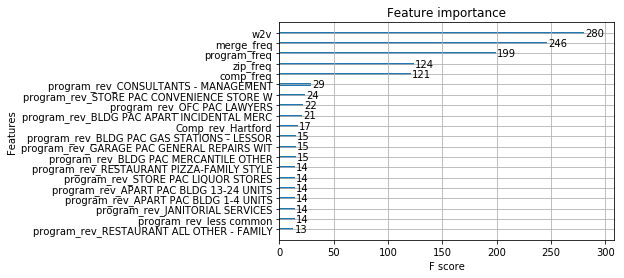

In [27]:
# plot feature importance
plot_importance(model, max_num_features=20)
plt.show()


In [28]:
#plot_tree(model, num_trees=0, rankdir='UT', ax=None)

In [29]:
#to_graphviz(model, num_trees=0, rankdir='UT', yes_color='#0000FF', no_color='#FF0000')

In [30]:
X.shape

(28105, 78)

In [31]:
# manually select features IOT preserve column names
indices = np.argsort(importances)[::-1][:35]
feat_top = X.columns[indices][0:35]
text_df = X[feat_top]


In [ ]:
# model_re = SelectFromModel(model, threshold='0.5*mean', prefit=True)
# feature_idx = model_re.get_support()
# feature_name = df_f.columns[feature_idx]
# X_re = model_re.transform(X)
# text_df = pd.DataFrame(X_re) 
# text_df.shape

In [32]:

text_df.to_csv('../data/processed3/text_df.csv', index=False)

In [33]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz 
clf = tree.DecisionTreeClassifier(max_depth=5) #class_weight="balanced")
clf = clf.fit(X, np.ravel(y))


ModuleNotFoundError: No module named 'graphviz'

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,  feature_names=X.columns,  
class_names=None,  filled=True, rounded=True, special_characters=True) 


graph = graphviz.Source(dot_data)  

graph.render('img/dtree_render_text1',view=True)